In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import regex as re
from lxml import etree as et
from itertools import repeat
import csv
import random
import time
import numpy as np
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

In [ ]:
header_list = ["Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML,                           like Gecko) Chrome/103.0.5060.66 Safari/537.36",
              "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:53.0) Gecko/20100101 Firefox/53.0",
              "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.79 Safari/537.36 Edge/14.14393"]

base_url = "https://www.flipkart.com"
smartwatch_brands = ['APPLE', 'Noise', 'boAt', 'Honor', 'SAMSUNG', 'FITBIT', 'Amazfit', 'GARMIN', 'Huawei', 'FOSSIL', 'Dizo', 'Gizmore', 'Amazfit', 'Ambrane', 'Pebble', 'Zebronics', 'fireboltt']
product_list = []

In [ ]:
for brand in tqdm_notebook(smartwatch_brands):
  for page_no in range(3):
    page_url = "https://www.flipkart.com/wearable-smart-devices/smart-watches/pr?sid=ajy%2Cbuh&otracker=categorytree&p%5B%5D=facets.brand%255B%255D%3D" + brand + '&page=' + str(page_no)
    user_agent = random.choice(header_list)
    header = {"User-Agent": user_agent}
    webpage = requests.get(page_url, headers = header)
    if webpage.status_code == 200:
      soup1 = BeautifulSoup(webpage.content, 'html.parser')
      soup2 = BeautifulSoup(soup1.prettify(), 'html.parser')
      divs = soup2.find_all('div', {'class' : '_1AtVbE col-12-12'} )
      for div in divs:
        swlink = div.find_all('a', {'class' : '_1fQZEK'})
        for l in swlink:
          print(l.get('href'))
          product_list.append(base_url + l.get('href'))

In [ ]:
print(len(product_list))

0


In [ ]:
cols = ['Url', 'Brand', 'Current Price', 'Original Price', 'Discount Percentage', 'Rating', 'Number OF Ratings', 'Highlights', 'Number of Models', 'Pictures']

specs_list = ['Sales Package', 'Model Number', 'Model Name', 'Dial Shape', 'Strap Color',
 'Strap Material', 'Size', 'Touchscreen', 'Water Resistant', 'Water Resistance Depth',
 'Usage', 'Dial Material', 'Ideal For', 'Compatible OS', 'Sensor', 'Compatible Device',
 'Notification', 'Battery Type', 'Battery Life', 'Rechargeable Battery', 'Charger Type',
 'Other Features', 'Operating System', 'Compatible Operating System', 'Processor Name',
 'Internal Memory', 'Call Function', 'Bluetooth', 'Wi-Fi', 'GPS', 'Bluetooth Version',
 'Other Connectivity Features', 'Display Resolution', 'Display Size', 'Display Type', 'Other Display Features', 'Calorie Count',
 'Step Count', 'Heart Rate Monitor', 'Altimeter', 'Other Fitness Features', 'Date & Time Display',
 'Compass', 'Calendar', 'Alarm Clock', 'Language', 'Number of Buttons', 'Speaker', 'Microphone',
 'Width', 'Thickness', 'Weight', 'Warranty Summary', 'Warranty Service Type',
 'Covered in Warranty', 'Not Covered in Warranty', 'Domestic Warranty']

description_list = ['Battery & Charger', 'Display', 'Design', 'Activity Tracking']

cols.extend(specs_list)
cols.extend(description_list)
flipkart = pd.DataFrame(columns = cols)

In [ ]:
def feature_result_transform(specs_list, dicted):
  
  result_list = []
  result_list.extend(repeat('-', len(specs_list)))

  for key in dicted.keys():
    for i in range(len(specs_list)):
      if specs_list[i] == key:
        result_list[i] = dicted[key]
  
  return result_list

In [ ]:
for link in tqdm_notebook(product_list):
  url = link
  webpage = requests.get(url, headers = header)
  if webpage.status_code == 200:
    soup1 = BeautifulSoup(webpage.content, 'html.parser')
    soup2 = BeautifulSoup(soup1.prettify(), 'html.parser')

    brand = re.split('-',re.split('https://www.flipkart.com/', url)[1])[0]

    try:
      cur_price = soup2.find('div', {'class' : '_30jeq3 _16Jk6d'})
      cur_price = int(re.sub('₹|,', '', cur_price.get_text().strip()))
    except:
      cur_price = ' - '
    try: 
      org_price = soup2.find('div', {'class' : '_3I9_wc _2p6lqe'})
      org_price = int(re.sub('₹|,', '', org_price.get_text().strip()))
    except:
      org_price = ' - '
    try:
      discount_perc = ((org_price - cur_price)/org_price)*100
    except:
      discount_perc = ' - '

    try:
      rating = soup2.find('div', {'class' : '_3LWZlK'})
      rating = rating.get_text().strip()
      #print(rating.get_text().strip())
    except:
      rating = ' - '

    try:
      nratings = soup2.find('span', {'class' : '_2_R_DZ'})
      nratings = nratings.get_text().strip().split()[0]
      #print(nratings.get_text().strip().split()[0])
    except:
      nratings = ' - '

    try:
      highlights = soup2.find('div', {'class' : '_1AtVbE col-6-12'})
      highlights = highlights.find_all('li', {'class' : '_21Ahn-'})
      highlights = [hl.get_text().strip() for hl in highlights]
      #print(highlights)
    except:
      highlights = ' - '

    tables = soup2.find_all('div', {'class' : '_3k-BhJ'})
    specs = []
    results = []
    for table in tables:
      s = table.find_all('td', {'class' : '_1hKmbr col col-3-12'})
      r = table.find_all('li', {'class' : '_21lJbe'})
      specs.extend([i.get_text().strip() for i in s])
      results.extend([i.get_text().strip() for i in r])
    # for i in range(len(specs)):
    #   print(f"{specs[i]} :: {results[i]}")
    
    dicted = {}
    for i in range(len(specs)):
      dicted[specs[i]] = results[i]

    try:
      nstraps = soup2.find('div', {'class' : '_22QfJJ'})
      nstraps = nstraps.find_all('li', {'class' : '_3V2wfe'})
      nstraps = len(nstraps)
      #print(nstraps)
    except:
      nstraps = ' - '

    try:
      pictures = soup2.find('div', {'class' : '_1AtVbE col-12-12'})
      pictures = pictures.find_all('li', {'class' : '_20Gt85 _1Y_A6W'})
      pictures = [p.find('img').get('src') for p in pictures][0]
      #print(pictures)
    except:
      pictures = ' - '

    try:
      box = soup2.find('div', {'class' : 'row _3AjFsn _2c2kV-'})
      boxes = box.find_all('div', {'class' : '_2a78PX'})
      votes, description = [], []
      for box in boxes:
        votes.append(box.find('text', {'class' : '_2Ix0io'}))
        description.append(box.find('div', {'class' : '_3npa3F'}))
      votes = [v.get_text().strip() for v in votes]
      description = [d.get_text().strip() for d in description]
      # for i in range(len(votes)):
      #   print(f"{description[i]} :: {votes[i]}")
      dicted2 = {}
      for i in range(len(description)):
        dicted2[description[i]] = votes[i]
    except:
      pass

    results = feature_result_transform(specs_list, dicted)
    votes = feature_result_transform(description_list, dicted2)
    row = [url, brand, cur_price, org_price, discount_perc, rating, nratings, highlights, nstraps, pictures]
    row.extend(results)
    row.extend(votes)
    flipkart.loc[len(flipkart.index)] = row


  0%|          | 0/72 [00:00<?, ?it/s]

In [ ]:
flipkart['Screen Size'] = np.nan
for i in range(len(flipkart)):
  ss = re.findall('(\d*\.\d+)', flipkart['Model Name'][i])
  if len(ss) == 1:
    flipkart['Screen Size'][i] = ss[0]

In [ ]:
 flipkart.head()

,Url,Brand,Current Price,Original Price,Discount Percentage,Rating,Number OF Ratings,Highlights,Number of Models,Pictures,...,Warranty Summary,Warranty Service Type,Covered in Warranty,Not Covered in Warranty,Domestic Warranty,Battery & Charger,Display,Design,Activity Tracking,Screen Size
0,https://www.flipkart.com/gizmore-gizfit-cloud-...,gizmore,1499,4499,66.681485,4.1,823,[1.85 Inch Bigger Display | Rotating Crown Con...,3,https://rukminim1.flixcart.com/image/128/128/x...,...,-,Service Centre,Only Manufacturing Defects,Any Physical Damages,1 Year,4.0,4.3,4.4,3.9,1.85
1,https://www.flipkart.com/gizmore-gizfit-cloud-...,gizmore,1499,4499,66.681485,4.1,823,[1.85 Inch Bigger Display | Rotating Crown Con...,3,https://rukminim1.flixcart.com/image/128/128/x...,...,-,Service Centre,Only Manufacturing Defects,Any Physical Damages,6 Months,4.0,4.3,4.4,3.9,1.85
2,https://www.flipkart.com/gizmore-gizfit-cloud-...,gizmore,1499,4499,66.681485,4.1,823,[1.85 Inch Bigger Display | Rotating Crown Con...,3,https://rukminim1.flixcart.com/image/128/128/x...,...,-,Service Centre,Only Manufacturing Defects,Any Physical Damages,1 Year,4.0,4.3,4.4,3.9,1.85
3,https://www.flipkart.com/gizmore-blaze-max-1-8...,gizmore,1599,5999,73.345558,4,"1,253",[1.85 Inch large IPS display with 240 x 280 px...,3,https://rukminim1.flixcart.com/image/128/128/x...,...,-,-,Only Manufacturing Defects,Any Physical Damages,12 Months,3.9,4.1,4.1,3.9,1.85
4,https://www.flipkart.com/gizmore-gizfit-ultra-...,gizmore,1499,5999,75.012502,4.2,"4,878",[1.69-inch full touch 2.5D HD curve metal Disp...,3,https://rukminim1.flixcart.com/image/128/128/x...,...,Gizmore Smartwatches Comes With 12 Months Manu...,Onsite,Only Manufacturing Defects,Any Physical Damage,1 Year,4.0,4.2,4.2,4.0,1.69


In [ ]:
flip = flipkart.drop_duplicates(subset = ['Model Number', 'Model Name'], keep = "first")
flip.reset_index(drop = True, inplace = True)
flip.shape

(22, 72)

In [ ]:
flip.to_csv('gizmore.csv')

In [ ]:
flip['Pictures'][0]

'https://rukminim1.flixcart.com/image/128/128/l572ufk0/smartwatch/y/s/i/1-39-orbit-styl-android-ios-crossbeats-no-original-imagfx66qaya5rfp.jpeg?q=70'

In [ ]:
for i in range(len(flip)):
  try:
    flip['Rating'][i] = float(flip['Rating'][i])
  except:
    flip['Rating'][i] = 0
  try:
    flip['Number OF Ratings'][i] = int(re.sub(',', '', flip['Number OF Ratings'][i]))
  except:
    flip['Number OF Ratings'][i] = 0
  try:
    flip['Pictures'][i] = flip['Pictures'][i][2:].split(',')[0][:-1]
  except:
    flip['Pictures'][i] = ' - '

In [ ]:
flipkart.to_csv('sw_flip_tableau.csv')

In [ ]:
flipkart.shape

(328, 71)

In [ ]:
flip.head()

,Url,Brand,Current Price,Original Price,Discount Percentage,Rating,Number OF Ratings,Highlights,Number of Models,Pictures,...,Weight,Warranty Summary,Warranty Service Type,Covered in Warranty,Not Covered in Warranty,Domestic Warranty,Battery & Charger,Display,Design,Activity Tracking
0,https://www.flipkart.com/apple-watch-se-gps-2n...,apple,29650,29900,0.83612,4.5,154,"[Retina LTPO OLED display, With Call Function,...",3,-,...,26.4 g,1 Year Manufacturer Warranty,Carry In,Manufacturing Defects,Physical Damage,1 Year,3.9,4.2,4.3,4.4
1,https://www.flipkart.com/apple-watch-se-gps-ce...,apple,37900,-,-,4.4,65,"[Retina LTPO OLED display, With Call Function,...",3,-,...,33 g,1 Year Manufacturer Warranty,Carry In,Manufacturing Defects,Physical Damage,1 Year,-,-,-,-
2,https://www.flipkart.com/apple-watch-series-3-...,apple,23349,23900,2.305439,4.6,55800,"[1-GPS, 2-Retina display, 3-Swimproof, 4-Optic...",3,-,...,-,1 Year Warranty,Carry In,Manufacturing Defects,Physical Damage,-,3.8,4.3,4.4,4.3
3,https://www.flipkart.com/apple-watch-se-gps-ce...,apple,33900,-,-,4.6,3440,"[GPS + Cellular model lets you call, text and ...",2,-,...,30.68 g,1 Year Manufacturer Warranty,Carry In,Manufacturing Defects,Physical Damage,1 Year,4.0,4.6,4.6,4.5
4,https://www.flipkart.com/apple-watch-ultra-gps...,apple,89900,-,-,4.7,51,"[Always-On Retina LTPO OLED display, With Call...",6,-,...,61.3 g,1 Year Manufacturer Warranty,Carry In,Manufacturing Defects,Physical Damage,1 Year,-,-,-,-


Preprocess :


In [ ]:
flip = pd.read_csv('sw_flip_tableau.csv')

In [ ]:
for i in range(len(flip)):
  try:
    if ('hours' or 'hrs' in flip['Battery Life'][i].lower()) and ('day' not in flip['Battery Life'][i].lower()):
      hours = int(re.findall('\d+', flip['Battery Life'][i])[0])
      if hours < 24:
        flip['Battery Life'][i] = 0.75
      elif hours == 24:
        flip['Battery Life'][i] = 1
      else:
        flip['Battery Life'][i] = 3.6
    else:
        days = int(re.findall('\d+', flip['Battery Life'][i])[0]) 
        if days < 1:
          flip['Battery Life'][i] = 0.75
        elif (days > 1) & (days < 6):
          flip['Battery Life'][i] = 3.5
        elif (days > 6) & (days < 11):
          flip['Battery Life'][i] = 8
        elif (days > 11) & (days < 16):
          flip['Battery Life'][i] = 12.5
        elif (days > 16) & (days < 21):
          flip['Battery Life'][i] = 17.5
        else:
          flip['Battery Life'][i] = 22
  except: 
    flip['Battery Life'][i] =np.nan

In [ ]:
flip['Strap Material'].value_counts()

In [ ]:
flip['Dial Shape'].value_counts()

Circle          131
Square          101
Rectangle        87
Curved            6
Contemporary      1
-                 1
Oval              1
Name: Dial Shape, dtype: int64

In [ ]:
flip['Water Resistance Depth'].value_counts()

-           126
50 m        120
1.5 m        22
1 m          14
5 m          13
30 m          9
10 m          5
2 m           5
100 m         4
52 m          4
51.67 m       2
10000 mm      1
50000 mm      1
50 mm         1
31 m          1
Name: Water Resistance Depth, dtype: int64

In [ ]:
flip['Internal Memory'].value_counts()

-        251
4 GB      32
32 GB     25
16 GB     14
8 GB       6
Name: Internal Memory, dtype: int64

In [ ]:
flip['Bluetooth Version'].value_counts()

-                                                               126
v5.0                                                             80
v4.2                                                             21
v5.1                                                             17
v5.2                                                             11
5                                                                 9
5.0                                                               7
v4.1                                                              7
v4.0                                                              6
v5                                                                4
5.1                                                               4
Bluetooth Smart Enabled / 4.1 Low Energy                          4
Bluetooth Smart Enabled / 4.2 Low Energy                          3
v5.0+v3.0                                                         3
v5.3                                            

In [ ]:
bt = ['5.0','5.1', '5.2', '4.0', '4.1', '4.2', '5.3', '3.0']
for i in range(len(flip)):
  try:
    if re.findall('\d.\d', flip['Bluetooth Version'][i])[0] in bt:
        flip['Bluetooth Version'][i] = 'v' + str(re.findall('\d.\d', flip['Bluetooth Version'][i])[0])
  except:
    flip['Bluetooth Version'][i] = 'v5.0'
flip['Bluetooth Version'].value_counts()

v5.0    243
v4.2     25
v5.1     22
v5.2     12
v4.1     12
v4.0      8
v5.3      3
v3.0      3
Name: Bluetooth Version, dtype: int64

In [ ]:
flip['Size'].value_counts()

Regular                          135
Free Size                         82
M                                 25
FREE SIZE                          8
Free size                          7
1.69                               5
L                                  4
1.32(34mm)                         3
1.8'' DISPLAY                      2
1.6'' DISPLAY                      2
1.69 inches                        2
25                                 2
REGULAR                            2
m                                  2
HD LARGE SCREEN                    2
1.7                                2
Small                              2
S,L                                2
free size                          1
1.39 DISPLAY SIZE                  1
4.4 x 3.6 x 0.9 cm                 1
1.3(33mm)                          1
1.78 display                       1
1.69'' DISPLAY                     1
1.3 DISPLAY                        1
1.7 inches                         1
1.4 inches                         1
1

In [ ]:
for i in range(len(flip)):
  flip['Display Resolution'][i] = ' '.join(flip['Display Resolution'][i].split(' ')[:-1]) + ' pixels'
flip['Display Resolution'].value_counts()

240 x 240 pixels           27
360 x 360 pixels           19
240 x 280 pixels           18
454 x 454 pixels           17
240*280 pixels             16
                           ..
72 x 154 pixels             1
416 x 416 pixels pixels     1
280 x 456 pixels            1
320 x 390 pixels            1
454*454 pixels              1
Name: Display Resolution, Length: 93, dtype: int64

In [ ]:
for i in range(len(flip)):
  try:
    if 'mm' in flip['Display Size'][i].lower():
      flip['Display Size'][i] = str(round(float(flip['Display Size'][i].split(' ')[0]) * 0.0393701, 1)) + ' inches'
    else:
      flip['Display Size'][i] = str(round(float(flip['Display Size'][i].split(' ')[0]), 1)) + ' inches'
  except:
    flip['Display Size'][i] = ' - '

In [ ]:
flip['Display Size'].value_counts()

1.3 inches     49
1.8 inches     44
1.7 inches     44
0.1 inches     36
1.4 inches     34
1.6 inches     28
1.2 inches     19
1.9 inches     15
0.2 inches      7
1.5 inches      6
0.9 inches      6
1.1 inches      6
1.0 inches      4
 -              3
4.3 inches      3
0.8 inches      2
20.0 inches     2
3.3 inches      2
2.7 inches      2
0.0 inches      1
2.3 inches      1
6.9 inches      1
3.5 inches      1
2.1 inches      1
33.0 inches     1
2.0 inches      1
45.0 inches     1
4.2 inches      1
18.5 inches     1
27.9 inches     1
3.0 inches      1
15.9 inches     1
0.6 inches      1
4.0 inches      1
2.4 inches      1
Name: Display Size, dtype: int64

In [ ]:
for i in range(len(flip)):
  try:
    w = float(flip['Width'][i].split(' ')[0])
    if (w < 41):
      flip['Width'][i] = '30 - 40 mm'
    elif (w > 40) & (w < 50):
      flip['Width'][i] = '40 - 50 mm'
    elif (w > 50) & (w < 100):
      flip['Width'][i] = '50 - 100 mm'
    elif (w > 100) & (w < 200):
      flip['Width'][i] = '100 - 200 mm'
    else:
      flip['Width'][i] = '200+ mm'
  except:
    flip['Width'][i] = ' - '

In [ ]:
flip['Width'].value_counts()

 -             214
30 - 40 mm      52
40 - 50 mm      44
200+ mm         14
50 - 100 mm      4
Name: Width, dtype: int64

In [ ]:
for i in range(len(flip)):
  try:
    w = float(flip['Weight'][i].split(' ')[0])
    if (w <= 20):
      flip['Weight'][i] = '<= 20 g'
    elif (w > 20) & (w < 36):
      flip['Weight'][i] = '20 - 35 g'
    elif (w > 35) & (w < 50):
      flip['Weight'][i] = '35 - 50 g'
    elif (w > 50) & (w < 75):
      flip['Weight'][i] = '50 - 75 g'
    else:
      flip['Weight'][i] = '75g +'
  except:
    flip['Weight'][i] = ' - '

In [ ]:
flip['Weight'].value_counts()

 -           161
35 - 50 g     70
20 - 35 g     38
50 - 75 g     35
75g +         20
<= 20 g        4
Name: Weight, dtype: int64

In [ ]:
for col in flip.columns:
  for i in range(len(flip)):
    try:
      if flip[col][i].strip() == '-':
        flip[col][i] = np.nan
    except:
      pass

In [ ]:
flip.to_csv('flip_final.csv')

In [ ]:
for i in range(len(flip)):
  try:
    flip['Original Price'][i] = int(flip['Original Price'][i])
  except:
    flip['Original Price'][i] = 
  flip['Current Price'][i] = int(flip['Current Price'][i])
  flip['Rating'][i] = int(flip['Rating'][i])
  try:
    flip['Number OF Ratings'][i] = int(re.sub(',', '', flip['Number OF Ratings'][i]))
  except:
    flip['Number OF Ratings'][i] = np.nan

ValueError: ignored

In [ ]:
flip = flip.drop('Unnamed: 0', axis = 1)
flip.reset_index(drop = True, inplace = True)

In [ ]:
flip.info()

In [ ]:
flip['Original Price'] = flip['Original Price'].astype(np.float64)
flip['Current Price'] = flip['Current Price'].astype(np.float64)
flip['Rating'] = flip['Rating'].astype(np.float64)
flip['Number OF Ratings'] = flip['Number OF Ratings'].astype(np.float64)
flip['Battery Life'] = flip['Battery Life'].astype(np.float64)

In [ ]:
flip.corr()

,Current Price,Original Price,Rating,Number OF Ratings,Battery Life
Current Price,1.000000,0.974829,0.411232,-0.192872,-0.100583
Original Price,0.974829,1.000000,0.343435,-0.150065,-0.249195
Rating,0.411232,0.343435,1.000000,0.108265,-0.132609
Number OF Ratings,-0.192872,-0.150065,0.108265,1.000000,0.024563
Battery Life,-0.100583,-0.249195,-0.132609,0.024563,1.000000


In [ ]:
import seaborn as sns
def corrplot(col):
  df = flip[['Current Price', col]]
  df = pd.get_dummies(df)
  sns.heatmap(df.corr(), cmap = "YlGnBu", annot = True)
  print(sorted(df.corr()['Current Price'][1:]))

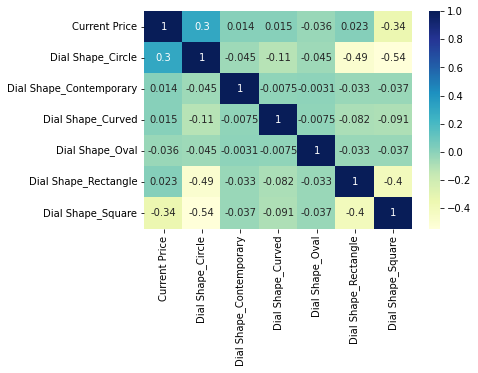

In [ ]:
corrplot('Dial Shape')

Circle followed by Rectangle

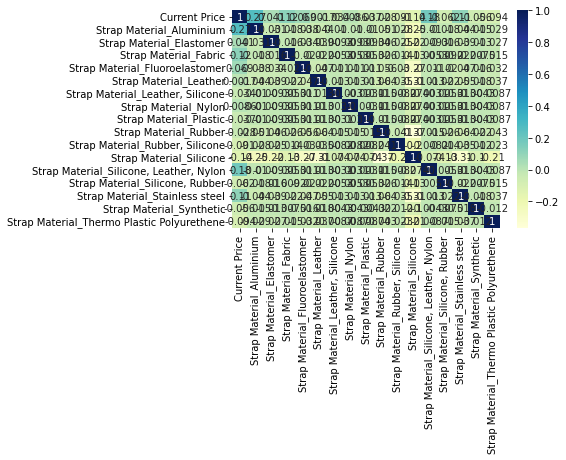

In [ ]:
corrplot('Strap Material')

Aluminium

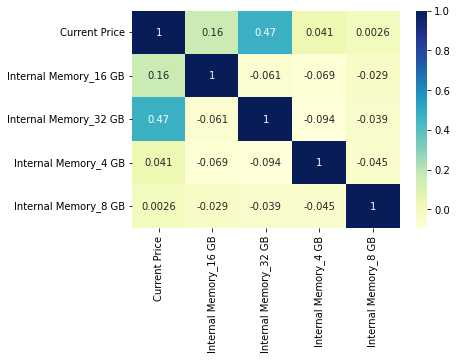

In [ ]:
corrplot('Internal Memory')

32 GB

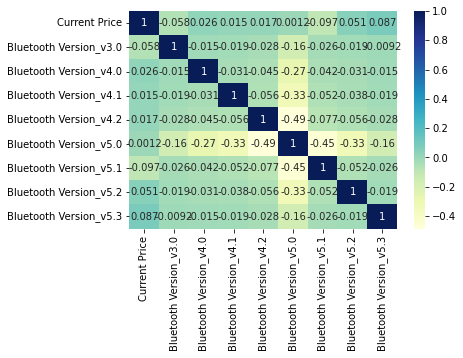

In [ ]:
corrplot('Bluetooth Version')

5.3 followed by 5.2

In [ ]:
df = flip[['Current Price', 'Display Size']]
df = pd.get_dummies(df)
sns.heatmap(df.corr(), cmap = "YlGnBu", annot = True)
print(sorted(df.corr()['Current Price'][1:]))

1.6 inches

[-0.1306563239894932, -0.049050848443637565, 0.025296175381582305, 0.06325035862086587]


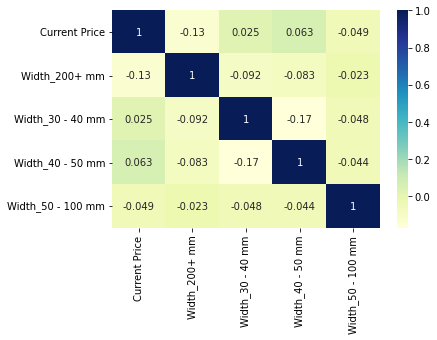

In [ ]:
corrplot('Width')

40-50 mm

In [ ]:
df = flip[['Current Price', 'Thickness']]
df = pd.get_dummies(df)
#sns.heatmap(df.corr(), cmap = "YlGnBu", annot = True)
df.corr()

Thickness : 14.4 mm

[-0.052807417350727984, -0.008819634400087381, 0.018273857781669085, 0.07653801237763352, 0.16509755241239496]


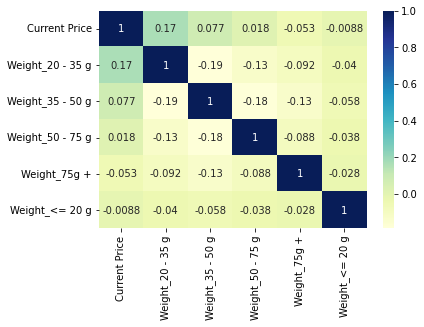

In [ ]:
corrplot('Weight')

Weight : 20 - 35g

Thickness : 14.4 mm

Width : 40-50 mm

Display Size : 1.6 inches

Bluetooth Version : 5.3 / 5.2

Internal Memory : 32 GB

Strap Material : Aluminium

Dial Shape : Circle followed by Rectangle